<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Local-Geometry" data-toc-modified-id="Local-Geometry-1">Local Geometry</a></span><ul class="toc-item"><li><span><a href="#Sentinel" data-toc-modified-id="Sentinel-1.1">Sentinel</a></span></li></ul></li><li><span><a href="#Vegetation-Indices" data-toc-modified-id="Vegetation-Indices-2">Vegetation Indices</a></span></li><li><span><a href="#Landscape" data-toc-modified-id="Landscape-3">Landscape</a></span></li><li><span><a href="#Fire-Mask" data-toc-modified-id="Fire-Mask-4">Fire Mask</a></span></li><li><span><a href="#Rainfall" data-toc-modified-id="Rainfall-5">Rainfall</a></span></li><li><span><a href="#Historical-Fire-Data" data-toc-modified-id="Historical-Fire-Data-6">Historical Fire Data</a></span></li><li><span><a href="#Fire-Analysis" data-toc-modified-id="Fire-Analysis-7">Fire Analysis</a></span></li><li><span><a href="#tp-plot" data-toc-modified-id="tp-plot-8">tp plot</a></span></li></ul></div>

In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-pastel')
%matplotlib inline

import ee 
import folium
import foliumgee
import geehydro
import geopy
# import geemap
import geemap.eefolium as geemap

# import proplot as plot 
from ipygee import*
from pandas.plotting import register_matplotlib_converters

import requests

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g7Bjkd70mqfBv-kuEjS_9kcethI8jdgEL5f8OdjXiF5coLGBQ0uj7w

Successfully saved authorization token.


In [7]:
!ls -l data/stc

total 55500
-rw-rw-r-- 1 vanessa vanessa 28599724 Jan 10 16:48 HistoricalWeather.csv
-rw-rw-r-- 1 vanessa vanessa 26072107 Jan 10 16:48 HistoricalWeatherForecasts.csv
-rw-rw-r-- 1 vanessa vanessa  2048982 Jan 10 16:48 Historical_Wildfires.csv
-rw-rw-r-- 1 vanessa vanessa      813 Jan 10 16:48 LandClass.csv
-rw-rw-r-- 1 vanessa vanessa    98276 Jan 10 16:48 VegetationIndex.csv


# Local Geometry

In [1]:
# paste JAVA script and run cell below to translate to python :)
js_snippet = """ 


"""

In [114]:
geemap.js_snippet_to_py(js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True)

In [ ]:
import ee
import geemap

Map = geemap.Map()

{
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        111.31156454547329,
        -39.24261434263115
      ],
      [
        154.6416426704733,
        -39.24261434263115
      ],
      [
        154.6416426704733,
        -10.241601774653487
      ],
      [
        111.31156454547329,
        -10.241601774653487
      ],
      [
        111.31156454547329,
        -39.24261434263115
      ]
    ]
  ]
}
Map


In [ ]:
# manual poly Area of Interest (AOI) from EEG
# aoi = ee.Geometry.Rectangle([-51.84448, -3.92180,
#                                    -52.23999, -4.38201])

In [13]:
# select shapefile for australia
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
aus_geo = countries.filter(ee.Filter.eq('country_na', 'Australia'))
type(aus_geo)

ee.featurecollection.FeatureCollection

In [16]:
# get central lat & lon
country = 'Australia'
locator = geopy.geocoders.Nominatim(user_agent="My app") 
country = locator.geocode(country)
location = country.latitude, country.longitude
print(country, "\n[lat, long]:", location)

Australia 
[lat, long]: (-24.7761086, 134.755)


In [21]:
# Map = geemap.Map()
Map = folium.Map(location=[location[0], location[1]], zoom_start=5)
Map.addLayer(aus_geo)
Map

## Sentinel

In [56]:
# see sentinel-2 data
Map = folium.Map(location=[location[0], location[1]], zoom_start=5)
time_frame = "2020-01-05","2020-01-12"
s2 = ee.ImageCollection("COPERNICUS/S2")
s2 = s2.filterBounds(australia).filterDate(time_frame[0], time_frame[1])
# filter bands  
Map.addLayer(s2,{'min':0, 'max':6000, 'bands':"B4,B3,B2"},"True color")
Map.addLayer(s2,{'min':0, 'max':6000, 'bands':"B11,B8,B4"},"False color")
Map

In [ ]:


# Add the two Sentinel layers into the folium map above
foliumgee.layer(myMap, s2_rgb, folium_kwargs={'overlay':True, 'name': 'Natural Colour'})
foliumgee.layer(myMap, s2_swir, folium_kwargs={'overlay':True, 'show': True, 'name': 'Short-wave Infrared'})

In [52]:
# import firms data
Map = folium.Map(location=[location[0], location[1]], zoom_start=5)
time_frame = "2020-01-01","2020-01-12"
firms = ee.ImageCollection("FIRMS")
firms = firms.filterBounds(australia).filterDate(time_frame[0], time_frame[1])
# filter bands                                                 
Map.addLayer(firms.max(),{'min':0, 'max':500, 'bands':"T21", 'palette':"yellow,orange,red"},"Brightness temperature")
# Map    

In [58]:
Map

# Vegetation Indices

In [53]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1')
modis = modis.filterDate(time_frame[0], time_frame[1])

evi = modis.select('EVI')
ndvi = modis.select('NDVI')

# see guide: [https://vip.arizona.edu/documents/MODIS/MODIS_VI_UsersGuide_June_2015_C6.pdf]
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image, 
                                             ['system:time_start'])

scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [68]:
Map = folium.Map(location=[location[0], location[1]], zoom_start=5, control_scale=True, detect_retina=True)
time_frame = '2017-01-01','2019-12-01'
# ee.DateRange(


Map.addLayer(scaled_ndvi.mean().clip(aus_geo),
                  vis_params={'min': 0,
                              'max': 1,
                              'palette': ['red', 'yellow','green'],
                              'name': 'mean_NDVI'})
Map

In [ ]:
# NDVI time series
aus_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': aus_geo,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
# aus_ndvi.renderWidget(width='50%')

In [ ]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(aus_ndvi.dataframe.index, aus_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')plot.show()

# Landscape

In [111]:
# Soil and Landscape Grid of Australia (Soil Attributes)
ee.ImageCollection("CSIRO/SLGA")
.filterDate(time_frame[0], time_frame[1])


Map = folium.Map(location=[location[0], location[1]], zoom_start=5, control_scale=True, detect_retina=True)
time_frame = '2017-01-01','2019-12-01'

Map.addLayer(scaled_ndvi.mean().clip(aus_geo),
                  vis_params={'min': 0,
                              'max': 1,
                              'palette': ['red', 'yellow','green'],
                              'name': 'mean_NDVI'})
Map

# Fire Mask

* MOD14A1 and MYD14A1 daily Level 3 fire products are tile-based, with each product filespanning one of the 460 MODIS tiles, of which 326 contain land pixels. The product is a 1-kmgridded composite of fire pixels detected in each grid cell over each daily (24-hour) compositingperiod. For convenience, eight days of data are packaged into a singlefile



In [76]:
# Thermal Anomalies and Fire Daily fire mask composites at 1km 
fire_terra = ee.ImageCollection("MODIS/006/MOD14A1").filterBounds(Australia).filterDate('2019-01-01','2019-06-01')

In [75]:
# Thermal Anomalies and Fire Daily fire mask composites at 1km 
Map = folium.Map(location=[location[0], location[1]], zoom_start=5) #, control_scale=True, detect_retina=True)
time_frame = '2017-01-01','2019-12-01'

fire_terra = ee.ImageCollection("MODIS/006/MOD14A1")
fire_terra.filterDate(time_frame[0], time_frame[1])

fire_mask = fire_terra.select("FireMask")

Map.addLayer(fire_mask)
# Map

In [ ]:
# // import sentinel-2 data
# var s2 = ee.ImageCollection("COPERNICUS/S2");
# // import firms data
# var firms = ee.ImageCollection("FIRMS");
# // import administrative data
# var countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");
 
# // filter for australia
# var australia = countries.filter(ee.Filter.eq("country_na","Australia"));
 
# // filter for relevant time period
# s2 = s2.filterBounds(australia).filterDate("2020-01-05","2020-01-12");
# firms =firms.filterBounds(australia).filterDate("2020-01-01","2020-01-12");
 
# // show the data
# Map.addLayer(s2,{min:0,max:6000,bands:"B4,B3,B2"},"true color");
# Map.addLayer(s2,{min:0,max:6000,bands:"B11,B8,B4"},"false color");
# Map.addLayer(firms.max(),{min:0,max:500,bands:"T21",palette:"yellow,orange,red"},"Brightness temperature");

In [101]:
poi = ee.Geometry.Point([-24.7761086, 134.755])
# poi = ee.Geometry.Point([76.5384, 11.7253])

s2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(poi).filterDate('2019-02-20', '2019-02-28').min()

# Specify visualisation parameters for Natural Colour and Short-wave Infrared images
s2_rgb = ee.Image(s2).visualize(min=300, max=2800, bands=['B4', 'B3', 'B2'])
s2_swir = ee.Image(s2).visualize(min=500, max=3300, bands=['B12', 'B8', 'B5'])

# Create a folium basemap into which EE layers above will be added
myMap = folium.Map(location=[-24.7761086, 134.755], zoom_start=12, tiles='Stamen Terrain', control_scale=True, detect_retina=True)

# Add the two Sentinel layers into the folium map above
foliumgee.layer(myMap, s2_rgb, folium_kwargs={'overlay':True, 'name': 'Natural Colour'})
foliumgee.layer(myMap, s2_swir, folium_kwargs={'overlay':True, 'show': True, 'name': 'Short-wave Infrared'})

# Add a layer control widget to the map
folium.LayerControl().add_to(myMap)

# Show the map!
myMap

In [104]:
s2.getInfo()

{'type': 'Image', 'bands': []}

In [108]:
# Function to get sizes in Human readable format
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

#Image Collection
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterDate('2019-08-01','2019-12-01').filterMetadata('CLOUD_COVER','less_than',2)

#bucket
vv_temp=ee.ImageCollection('content/collab/aus_fire_bucket').filterDate('2019-08-01','2019-12-01')

# Get collection size
print('Total number of LS-8 assets with filters: '+str(l8sr.size().getInfo()))
print('Total number of assets with filters: '+str(vv_temp.size().getInfo()))
print('\n'+'Total size of LS-8 collection : '+str(humansize(l8sr.reduceColumns(ee.Reducer.sum(), ['system:asset_size']).getInfo()['sum'])))
print('Total size of collection : '+str(humansize(vv_temp.reduceColumns(ee.Reducer.sum(), ['system:asset_size']).getInfo()['sum'])))


Total number of LS-8 assets with filters: 10681
Total number of PS assets with filters: 1046

Total size of LS-8 collection : 5.68 TB
Total size of PS collection : 161.51 GB


# Rainfall

In [70]:
js_snippet = """ 
// Lab: Plot Rainfall Time Series

// Define countries boundary
var countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017');
var Australia = countries.filter(ee.Filter.eq('country_na', 'Australia'));

// Import rainfall data
var rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
.select('precipitation')
.filterDate('2019-01-01','2019-06-01')
.filterBounds(Australia);

// Display rainfall time series 
print(ui.Chart.image.series(rainfall, Australia, ee.Reducer.mean(), 1000));

// Display rainfall seasonality 
var chart2 = ui.Chart.image.doySeries(
    rainfall, Australia, ee.Reducer.mean(), 1000);
print(chart2);

// Display rainfall annual variation
var chart3 = ui.Chart.image.doySeriesByYear(
    rainfall, 'precipitation', Australia, ee.Reducer.mean(), 1000);
print(chart3);
"""

In [71]:
geemap.js_snippet_to_py(js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True)

In [ ]:
import ee
import geemap

Map = geemap.Map()


# Define countries boundary
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
Australia = countries.filter(ee.Filter.eq('country_na', 'Australia'))

# Import rainfall data
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
.select('precipitation') \
.filterDate('2019-01-01','2019-06-01') \
.filterBounds(Australia)

# Display rainfall time series
print(ui.Chart.image.series(rainfall, Australia, ee.Reducer.mean(), 1000))

# Display rainfall seasonality
chart2 = ui.Chart.image.doySeries(
    rainfall, Australia, ee.Reducer.mean(), 1000)
print(chart2)

# Display rainfall annual variation
chart3 = ui.Chart.image.doySeriesByYear(
    rainfall, 'precipitation', Australia, ee.Reducer.mean(), 1000)
print(chart3)
Map


In [ ]:
url = '
south_wales_local = pd.read_json(url)
south_wales_local.head(2)

# Historical Fire Data

In [17]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack

In [4]:
path_wildfires = "data/stc/Historical_Wildfires.csv"
wildfires_df = pd.read_csv(path_wildfires)
wildfires_df['Date'] = pd.to_datetime(wildfires_df['Date'])
wildfires_df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [13]:
wildfires_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Estimated_fire_area,26406.0,144.297966,314.453847,1.0,8.911875,38.434091,146.951278,10120.943170
Mean_estimated_fire_brightness,26406.0,319.662078,8.862005,290.7,313.933333,319.784412,325.403144,381.950000
Mean_estimated_fire_radiative_power,26406.0,83.621258,67.510022,0.0,44.150391,67.133333,103.123611,2178.600000
Mean_confidence,26406.0,87.574735,4.371972,76.0,85.000000,87.771429,90.498403,100.000000
Std_confidence,24199.0,7.228302,1.995221,0.0,6.687010,7.707025,8.236665,16.970563
Var_confidence,24199.0,56.229092,25.898935,0.0,44.716106,59.398234,67.842642,288.000000
Count,26406.0,72.059305,150.973128,1.0,5.000000,20.000000,74.000000,3954.000000


In [14]:
print("Number of rows: {}".format(len(wildfires_df)))
print("Number of regions: {}\n".format(len(wildfires_df['Region'].unique())))
print(wildfires_df['Region'].unique())

Number of rows: 26406
Number of regions: 7

['NSW' 'NT' 'QL' 'SA' 'TA' 'VI' 'WA']


In [24]:
fire_area = wildfires_df[["Date", "Estimated_fire_area", 'Region']].set_index('Date')
fire_area

,Estimated_fire_area,Region
Date,,
2005-01-04,8.680000,NSW
2005-01-05,16.611250,NSW
2005-01-06,5.520000,NSW
2005-01-07,6.264000,NSW
2005-01-08,5.400000,NSW
...,...,...
2020-10-27,32.970000,WA
2020-10-28,20.840625,WA
2020-10-29,136.083077,WA


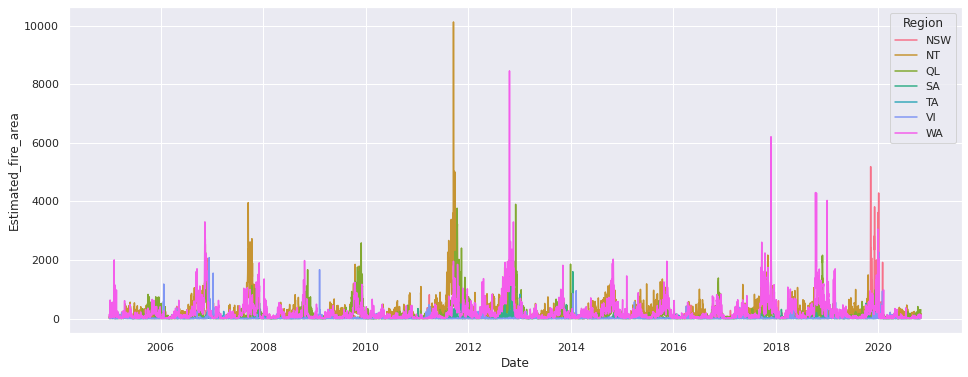

In [116]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', data=wildfires_df)

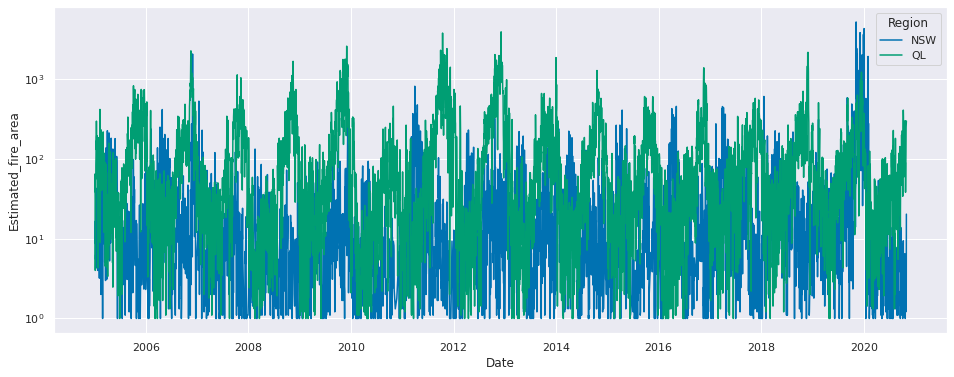

In [79]:
plt.figure(figsize=(16, 6))
plt.style.use("seaborn-colorblind")

g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', 
                 data = wildfires_df[ 
                     (wildfires_df['Region']=='NSW') | (wildfires_df['Region']=='QL')])
g.set_yscale("log")

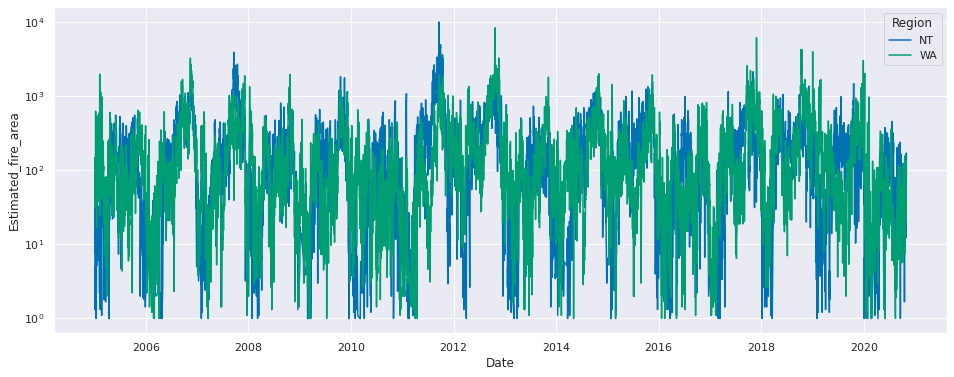

In [80]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region',
                 data = wildfires_df[ (wildfires_df['Region']=='WA') | (wildfires_df['Region']=='NT') ])
g.set_yscale("log")

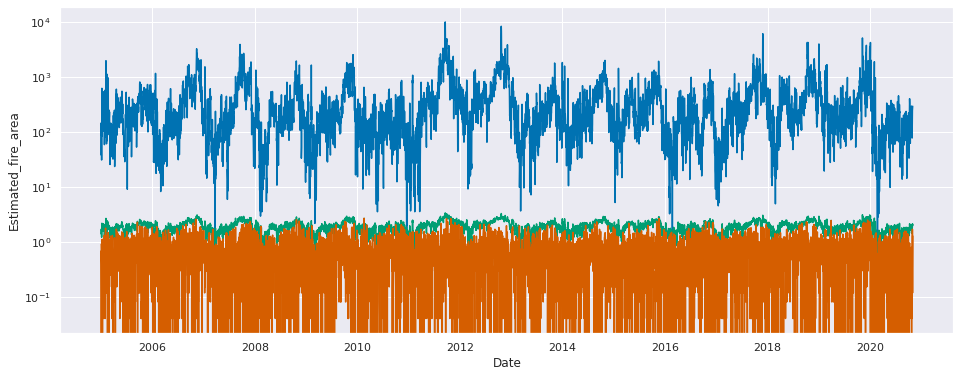

In [97]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="Date", y="Estimated_fire_area", 
                 data = wildfires_df.groupby(['Date']).max()  ).set_yscale("log")

sns.lineplot(x="Date", y="Estimated_fire_area", 
                 data = wildfires_df.groupby(['Date']).mean()  ).set_yscale("log")

sns.lineplot(x="Date", y="Estimated_fire_area", 
                 data = wildfires_df.groupby(['Date']).min()  ).set_yscale("log")

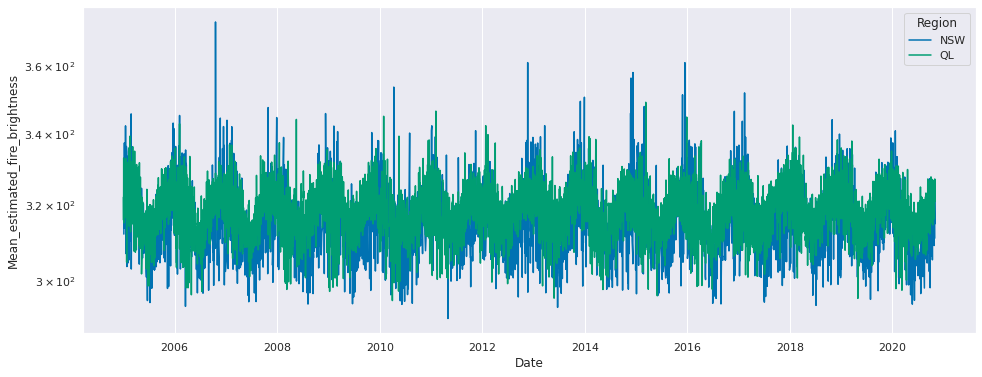

In [98]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="Date", y="Mean_estimated_fire_brightness",hue='Region', 
                 data = wildfires_df[ 
                     (wildfires_df['Region']=='NSW') | (wildfires_df['Region']=='QL')]).set_yscale("log")

Text(0, 0.5, 'PSD (dB)')

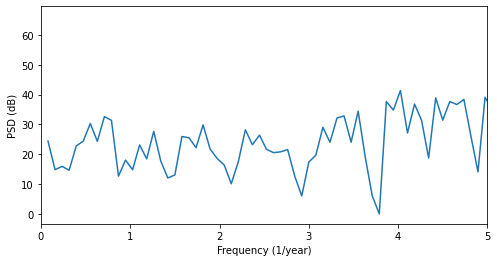

In [49]:
fire_area_NSW = fire_area[fire_area["Region"] == 'NSW'].drop(columns="Region")
# Fourier transform and the power spectral density of the signal
fft_fire_area = sp.fftpack.fft(fire_area_NSW)
# power spectral density
temp_psd = np.abs(fft_fire_area) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 365)
i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')

# Fire Analysis

# tp plot

Figure presents the thermal radiation coming from actively burning vegetation and other open fires for 12 October 2011. The data is derived from SEVIRI (LSA SAF) and MODIS (NASA) and calculated as daily averages of FRP in 125 km grid cells [mW/m2]. This (daily average) FRP areal intensity data is computed within the D-Fire subproject